# Imports


In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

# Access functions

In [2]:
def retrieve_time(path):
    """
    This function retrieves the timing of a certain measurement.

    Input:
     - path: inner path to the folder containing a result (consider to address a path/job.out)

    Output:
     - A float representing time or an error
    """
    f = open(path + "/job.out", "r")
    return float(f.readlines()[1][6:])

In [3]:
def retrieve_settings(path):
    """
    This function retrieves all the settings for a certain measurement.

    Input:
     - path: inner path to the folder containing a result (consider to address a path/job.out)

    Output: 
     - A numpy array of settings in format np.float64
    """
    options = path.split("/")
    settings = np.array([], dtype=np.float64)
    for set in options:
        if not str.isalpha(set.split("_")[-1]):
            settings = np.append(settings, np.float64(set.split("_")[-1]))
            
    return settings

In [4]:
# These indexes allow us to rapidly swap the number of parameter in consideration during generation.

sequential_idx = {"seq_length": 0, "patterns": 1, "mean_path_length": 2, "time": 3}
pthreads_idx = {"threads": 0, "seq_length": 1, "patterns": 2, "mean_path_length": 3, "time": 4}

# Dataset creation

In [5]:
def create_dataset(path, dataset):
    """
    This function recursively explores the results folder and gathers data about the measurements.

    Input:
     - path: the path of the dataset
     - dataset: whatever numpy array of np.float64 with the same dimension as the measurement variables

     Output: 
      - The dataset as a numpy array of np.float64. The shape of the array is (measurements, variables),
        where the last variable is the timing of the measurement
    """
    new_dataset = np.copy(dataset)
    if not os.path.isdir(path) or os.listdir(path) == []:
        return dataset
    elif "job.out" in os.listdir(path):
        try:
            time = retrieve_time(path)
            settings = retrieve_settings(path)
            row = np.append(settings, np.float64(time)).reshape(1, -1)
            return np.append(new_dataset, row, axis=0)
        except:
            return new_dataset
    else:
        for dir in os.listdir(path):
            new_dataset = create_dataset(path + "/" + dir, new_dataset)

    return new_dataset

In [6]:
# Testing

pthreads_times = create_dataset("results/logs/pthreads", np.zeros(shape=(1, len(sequential_idx)), dtype=np.float64))

## Data retrieval


In [7]:
pthreads = create_dataset("results/logs/pthreads", np.zeros(shape=(1, len(pthreads_idx)), dtype=np.float64))[1:, :]
sequential = create_dataset("results/logs/sequential", np.zeros(shape=(1, len(sequential_idx)), dtype=np.float64))[1:, :]

pthreads[:, 1:-1] = np.power(2, pthreads[:, 1:-1])
sequential[:, :-1] = np.power(2, sequential[:, :-1])

In [8]:
sequential

array([[3.35544320e+07, 1.02400000e+03, 2.56000000e+02, 3.67757448e+02],
       [3.35544320e+07, 1.02400000e+03, 1.02400000e+03, 3.69464788e+02],
       [3.35544320e+07, 1.02400000e+03, 6.40000000e+01, 4.34877357e+02],
       [3.35544320e+07, 1.02400000e+03, 4.09600000e+03, 3.66884117e+02],
       [3.35544320e+07, 1.02400000e+03, 1.04857600e+06, 4.11617661e+02],
       [1.02400000e+03, 1.02400000e+03, 2.56000000e+02, 6.72600000e-03],
       [1.02400000e+03, 1.02400000e+03, 1.02400000e+03, 6.93000000e-04],
       [1.02400000e+03, 1.02400000e+03, 1.60000000e+01, 6.39600000e-03],
       [1.02400000e+03, 1.02400000e+03, 6.40000000e+01, 8.00800000e-03],
       [1.02400000e+03, 1.04857600e+06, 2.56000000e+02, 7.99015300e+00],
       [1.02400000e+03, 1.04857600e+06, 1.02400000e+03, 8.33288000e-01],
       [1.02400000e+03, 1.04857600e+06, 1.60000000e+01, 7.42410700e+00],
       [1.02400000e+03, 1.04857600e+06, 6.40000000e+01, 8.60292700e+00],
       [1.02400000e+03, 3.27680000e+04, 2.56000000e

## Possible values of each variable

In [9]:
def domain(dataset, variable):
    """
    This function retrieves all the possible values of the dataset EXCLUDING the given variable and time. 
    
    For example, if the variable is seq_length and the dataset is
    
    [seq_length | patterns | mean_path_length | time] //this line is not actually part of the array
    
    [[10          10         4                   0.012]\n
    [15          10         4                   0.030]\n
    [20          15         4                   0.70]]\n

    the output will be

    [patterns | mean_path_length] //this line is not actually part of the array
    
    [[10        4]\n
    [15         4]]\n

    Input:
     - dataset: the output of create_dataset
     - variable: a value of an index dictionary (e.g. sequential_idx), whose column will
       be excluded when creating the set of unique values. Make sure the column actually matches
       the content of the given dataset

    Output:
     - a numpy array containing the described result 
    """
    return np.unique(np.delete(dataset, variable, axis=1)[:, :-1], axis=0)

In [10]:
# Testing

domain(sequential, sequential_idx["patterns"])

array([[1.0240000e+03, 1.6000000e+01],
       [1.0240000e+03, 6.4000000e+01],
       [1.0240000e+03, 2.5600000e+02],
       [1.0240000e+03, 1.0240000e+03],
       [3.3554432e+07, 6.4000000e+01],
       [3.3554432e+07, 2.5600000e+02],
       [3.3554432e+07, 1.0240000e+03],
       [3.3554432e+07, 4.0960000e+03],
       [3.3554432e+07, 1.0485760e+06]])

# Comparing datasets


In [11]:
def comparison(dataset1, method1_idx, dataset2, method2_idx, variable):
    """
    This function returns an array that compares two datasets on a given variable x.
    It creates an array for each configuration of all the other variables that are not x, 
    effectively comparing the 2 methods as a result of varying a single variable.

    Input:
     - dataset1: an output of create_dataset
     - method1_idx: the dictionary of variables and indices associated to the first dataset
     - dataset2: an output of create_dataset
     - method2_idx: the dictionary of variables and indices associated to the second dataset
     - variable: the variable we are comparing on

    Output:
     - Two arrays with shape (configurations, range(variable)*measurements_per_configuration, len(methodj_idx) + 1),
       one per datset, where:
        - configurations is the output length of domain(datasetj, variable)
        - range(variable) is the number of total settings for that specific variable
        - measurements_per_configuration is the number of measurements per each experiment setting (including the variable itself)
        - len(methodj_idx) is the number of variables of a certain datset
        
        Mind that the last 2 dimensions are a numpy array.
    """
    new_dataset1 = []
    new_dataset2 = []
    for const in domain(dataset1, method1_idx[variable]):
        values = np.copy(dataset1)
        for i in range(dataset1.shape[1] - 2):
            if i >= method1_idx[variable]:
                values = values[(values[:, i+1] == const[i])]
            else:
                values = values[(values[:, i] == const[i])]
        new_dataset1.append(values)

    for const in domain(dataset2, method2_idx[variable]):
        values = np.copy(dataset2)
        for i in range(1, dataset2.shape[1] - 2):
            if i >= method2_idx[variable]:
                values = values[(values[:, i+1] == const[i])]
            else:
                values = values[(values[:, i] == const[i])]
        new_dataset2.append(values)
            
    return new_dataset1, new_dataset2

In [12]:
def sequential_vs_pthreads(variable):
    """
    A wrapper of the comparison function for sequential and pthreads data.
    """
    return comparison(sequential, sequential_idx, pthreads, pthreads_idx, variable)

In [13]:
# Testing

sequential_vs_pthreads("patterns")

([array([[1.024000e+03, 1.024000e+03, 1.600000e+01, 6.396000e-03],
         [1.024000e+03, 1.048576e+06, 1.600000e+01, 7.424107e+00],
         [1.024000e+03, 3.276800e+04, 1.600000e+01, 2.010460e-01]]),
  array([[1.024000e+03, 1.024000e+03, 6.400000e+01, 8.008000e-03],
         [1.024000e+03, 1.048576e+06, 6.400000e+01, 8.602927e+00],
         [1.024000e+03, 3.276800e+04, 6.400000e+01, 2.519510e-01]]),
  array([[1.024000e+03, 1.024000e+03, 2.560000e+02, 6.726000e-03],
         [1.024000e+03, 1.048576e+06, 2.560000e+02, 7.990153e+00],
         [1.024000e+03, 3.276800e+04, 2.560000e+02, 2.143180e-01]]),
  array([[1.024000e+03, 1.024000e+03, 1.024000e+03, 6.930000e-04],
         [1.024000e+03, 1.048576e+06, 1.024000e+03, 8.332880e-01],
         [1.024000e+03, 3.276800e+04, 1.024000e+03, 3.018100e-02]]),
  array([[3.35544320e+07, 1.02400000e+03, 6.40000000e+01, 4.34877357e+02]]),
  array([[3.35544320e+07, 1.02400000e+03, 2.56000000e+02, 3.67757448e+02]]),
  array([[3.35544320e+07, 1.024000

# Comparison plotting

## Sequential vs PThreads

In [36]:
def plot_variable_sequential_pthreads(variable):
    """
    This function creates plots of pthreads and sequential corresponding to the arrays created in comparison.
    Check comparison's description for a thorough explanation.

    Input:
     - variable: the variable we are comparing on

    Output:
     - a multifaceted graph of time vs variable, where each facet is a fixed configuration
       of the other variables (again, check comparison's description)
    """
    # Grouping measurements by fixing all the other variables but the chosen one
    # Check sequntial_vs_pthreads for more info
    x_sequential, x_pthreads = sequential_vs_pthreads(variable)

    # Setting up the plots
    fig, axis = plt.subplots(len(x_sequential))

    # Fixing the interesting indexes
    seq_idx = sequential_idx[variable]
    pth_idx = pthreads_idx[variable]

    # Plotting each and every grouping
    for i, data in enumerate(zip(x_sequential, x_pthreads)):
        seq = data[0]
        pth = data[1]

        # Checking that groupings have at least two measurements
        if (seq.shape[0] < 2 or pth.shape[0] < 2):
            print(f"Configuration {np.array2string(seq[0, :-1])} has been skipped due to lack of data")
            print(f"Sequential data has {seq.shape[0]} datapoints")
            print(f"PThreads data has {pth.shape[0]} datapoints")
            fig.delaxes(axis[i])
            continue

        # Ordering groupings by the interesting variable
        seq = seq[np.argsort(seq[:,seq_idx])]
        pth = pth[np.argsort(pth[:,pth_idx])]

        # Checking the groupings actually contain the same constants
        #if np.equal(np.unique(seq[:, :-1], axis=0), np.unique(pth[:, 1:-1], axis=0)).all():          
        # Plotting the sequential datapoints for the chosen grouping
        axis[i].plot(seq[:, seq_idx], seq[:, -1], color='black', label = "Sequential")

        # Plotting the pthreads datapoints for the chosen grouping:
        # We need to group again on each thread number
        # THIS PART MUST BE CHANGED IF THE NUMBER OF VARIABLES CHANGES
        for j, colour in zip(sorted(set(pth[:, 0])), ("red", "blue", "yellow", "green")):
            pth_group = pth[pth[:, 0] == j]
            pth_label = str(int(pth_group[0, 0])) + " threads"

            axis[i].plot(pth_group[:, pth_idx], pth_group[:, -1], color=colour, label = pth_label)
        # Finishing the plot
        title = ""
        for k in sequential_idx.keys():
            if k != variable and k != "time":
                title += k + "=" + str(seq[0, sequential_idx[k]]) + "\n"
        axis[i].set_title(title)
        axis[i].set_xlabel(variable)
        axis[i].set_ylabel('Time (s)')
        axis[i].set_yscale('log')
        axis[i].set_xscale('log', base = 2)
        axis[i].legend()
        axis[i].grid()
        
    fig.set_figheight(50)
    plt.legend()
    plt.tight_layout()
    plt.show()

Configuration [3.3554432e+07 1.0240000e+03 6.4000000e+01] has been skipped due to lack of data
Sequential data has 1 datapoints
PThreads data has 4 datapoints
Configuration [3.3554432e+07 1.0240000e+03 2.5600000e+02] has been skipped due to lack of data
Sequential data has 1 datapoints
PThreads data has 4 datapoints
Configuration [3.3554432e+07 1.0240000e+03 1.0240000e+03] has been skipped due to lack of data
Sequential data has 1 datapoints
PThreads data has 4 datapoints
Configuration [3.3554432e+07 1.0240000e+03 4.0960000e+03] has been skipped due to lack of data
Sequential data has 1 datapoints
PThreads data has 4 datapoints
Configuration [3.3554432e+07 1.0240000e+03 1.0485760e+06] has been skipped due to lack of data
Sequential data has 1 datapoints
PThreads data has 4 datapoints


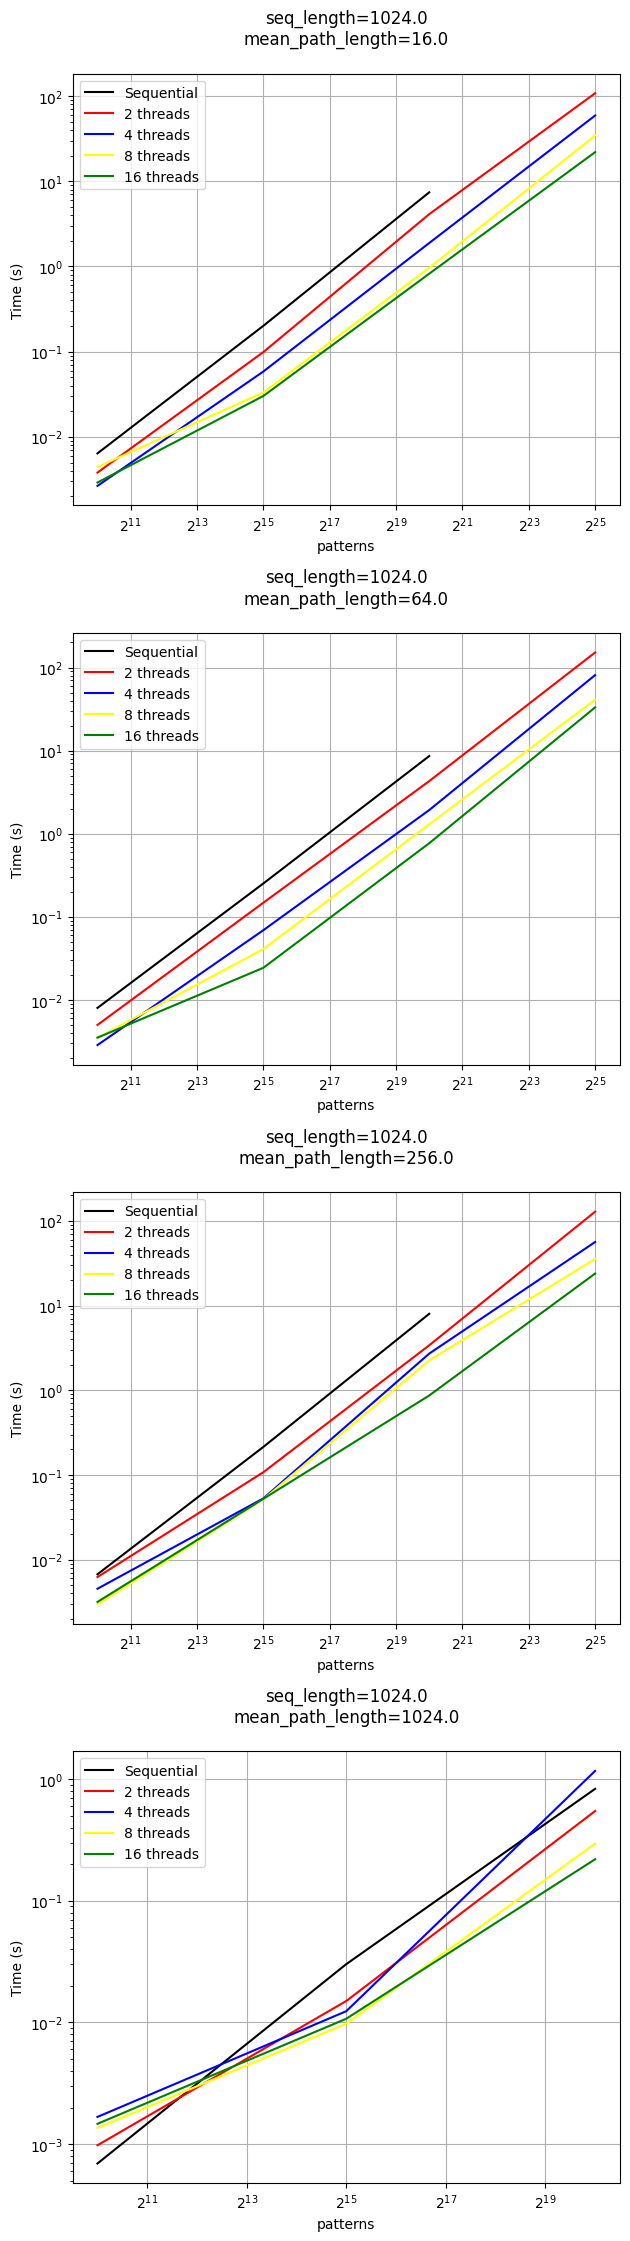

In [39]:
plot_variable_sequential_pthreads("patterns")